## Reference
https://www.machinelearningplus.com/nlp/gensim-tutorial/ -- Gensim introduction

https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis -- Using Gensim for sentiment analysis

https://www.kaggle.com/zjxuan/regression-model-for-sentiment-analysis/notebook -- Simple logistics regression

https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/analyze-tweet-sentiments-in-python/ -- TextBlob Analysis



**IMPORTING DATASET TO DRIVE_CHECK LOCATION**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**PREPARATION**

In [2]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#Pytorch
import torch
from torchvision import datasets, models, transforms

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set up directory
dir = '/content/gdrive/My Drive/Internship document/Softbank AI Lab/'
checkpoint_path = dir + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 15
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.1)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**READ DATASET**

Dataset size: 1600000
CPU times: user 3.6 s, sys: 304 ms, total: 3.91 s
Wall time: 4.57 s


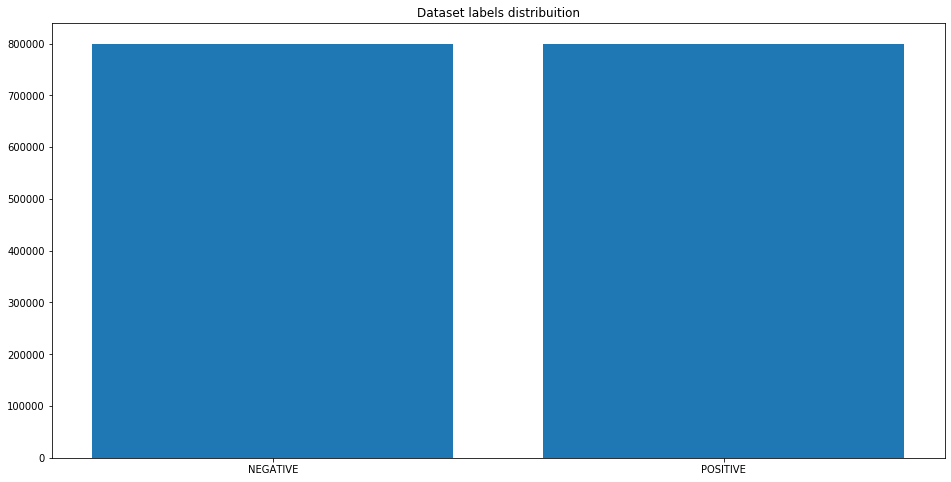

In [3]:
%%time
df = pd.read_csv(dir + 'Twitter_dataset.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Dataset size:", len(df))

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.target = df.target.apply(lambda x: decode_sentiment(x))
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Pre-process dataset

In [4]:
#Remove stopwords, collect only stemwords
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)

CPU times: user 35.9 s, sys: 145 ms, total: 36.1 s
Wall time: 36.1 s


Gensim W2V model

In [5]:
#Gensim model to convert words to vector
%%time
# documents = [_text.split() for _text in df_train.text]
# w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
# w2v_model.build_vocab(documents)
# words = w2v_model.wv.vocab.keys()
# vocab_size = len(words)
# print("Vocab size", vocab_size)

# %%time
# # Training W2V model
# w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

#loading W2V model
w2v_model = torch.load(F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/word2vec.model")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 41.6 s, sys: 583 ms, total: 42.2 s
Wall time: 42.7 s


Label Encoder

In [0]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Build model

In [25]:
#Embedding layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

#Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# save the model according to the conditions  
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
ReduceLRON = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
early = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)

#Compile model & Callback
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
callbacks = [checkpoint, ReduceLRON, early]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-03 13:36:40,198 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train

In [55]:
#Load model
model = torch.load(F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/model.h5")

#Train model
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 322s 280us/step - loss: 0.6554 - accuracy: 0.6073 - val_loss: 0.6364 - val_accuracy: 0.6459
Epoch 2/8


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 311s 270us/step - loss: 0.6548 - accuracy: 0.6085 - val_loss: 0.6377 - val_accuracy: 0.6427
Epoch 3/8
1152000/1152000 [==============================] - 309s 268us/step - loss: 0.6534 - accuracy: 0.6096 - val_loss: 0.6353 - val_accuracy: 0.6449
Epoch 4/8
1152000/1152000 [==============================] - 308s 267us/step - loss: 0.6514 - accuracy: 0.6120 - val_loss: 0.6328 - val_accuracy: 0.6427
Epoch 5/8
1152000/1152000 [==============================] - 308s 267us/step - loss: 0.6476 - accuracy: 0.6155 - val_loss: 0.6298 - val_accuracy: 0.6480
Epoch 6/8
1152000/1152000 [==============================] - 307s 267us/step - loss: 0.6439 - accuracy: 0.6187 - val_loss: 0.6247 - val_accuracy: 0.6534
Epoch 7/8
1152000/1152000 [==============================] - 306s 266us/step - loss: 0.6431 - accuracy: 0.6200 - val_loss: 0.6267 - val_accuracy: 0.6483
Epoch 8/8
1152000/1152000 [==============================] - 307s 266us/step - loss: 0.6391 

Evaluate

320000/320000 [==============================] - 40s 126us/step

ACCURACY: 0.6577906012535095
LOSS: 0.6186838855743408


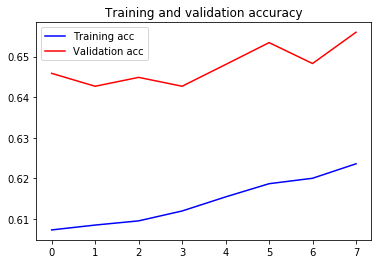

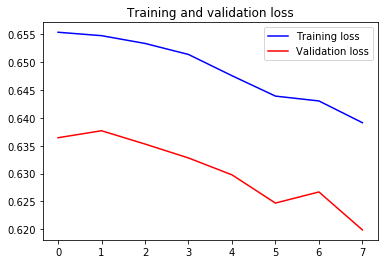

CPU times: user 53.7 s, sys: 3.13 s, total: 56.8 s
Wall time: 40.5 s


In [56]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict

In [17]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)
    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

320000/320000 [==============================] - 16s 49us/step


In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

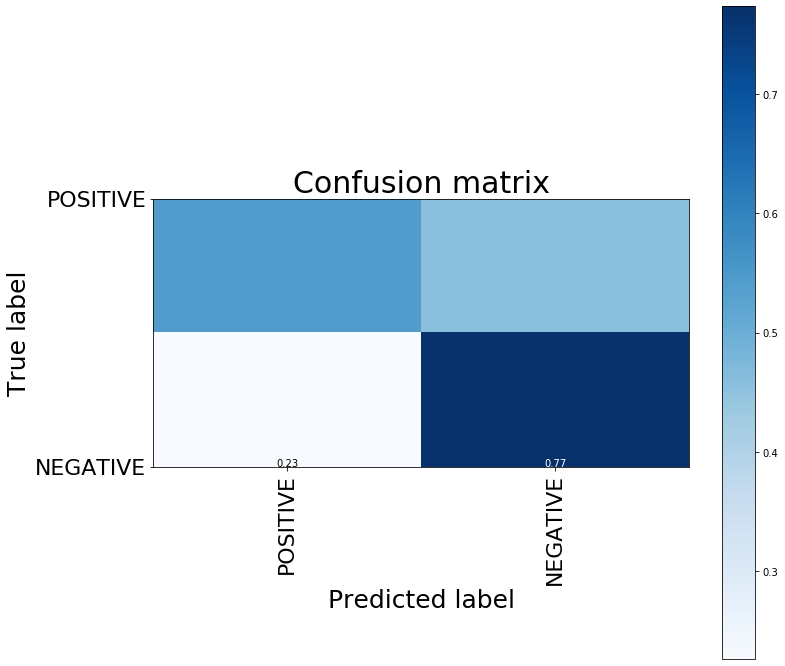

CPU times: user 1.01 s, sys: 91.9 ms, total: 1.1 s
Wall time: 1.16 s


In [58]:
%%time
#Predict the result
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

#Plot the matrix
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [59]:
print(classification_report(y_test_1d, y_pred_1d))
print('Accuracy score:', accuracy_score(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.54      0.61    159494
    POSITIVE       0.63      0.77      0.69    160506

    accuracy                           0.66    320000
   macro avg       0.67      0.66      0.65    320000
weighted avg       0.67      0.66      0.65    320000

Accuracy score: 0.657790625


Saving model

In [0]:
#saving model into Google drive
model_save_name = 'word2vec.model'
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/{model_save_name}" 
torch.save(w2v_model, path)

model_save_name = "model.h5"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/{model_save_name}" 
torch.save(model, path)

model_save_name = "tokenizer.pkl"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/{model_save_name}" 
torch.save(TOKENIZER_MODEL, path)

model_save_name = "encoder.pkl"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/{model_save_name}" 
torch.save(ENCODER_MODEL, path)

Running simple regression model

In [9]:
%%time
vectorizer = TfidfVectorizer()
word_frequency = vectorizer.fit_transform(df.text)
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 10min 1s, sys: 800 ms, total: 10min 2s
Wall time: 10min 3s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
#Save clf result
model_save_name = "clf.model"
path = F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/{model_save_name}" 
torch.save(clf, path)

In [7]:
%%time
#Load model
clf = torch.load(F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/clf.model")

Y_predict = clf.predict(x_test)
print(classification_report(y_test, Y_predict))
print ('Accuracy: ', accuracy_score(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.50      0.02      0.04    159494
           1       0.50      0.98      0.66    160506

    accuracy                           0.50    320000
   macro avg       0.50      0.50      0.35    320000
weighted avg       0.50      0.50      0.35    320000

Accuracy:  0.5016125
CPU times: user 682 ms, sys: 236 ms, total: 918 ms
Wall time: 734 ms


In [11]:
sum(Y_predict)/len(Y_predict)

0.98165

### CLEANING THE NEW DATA

In [12]:
#Import the dataset that we will use to classify
HongKong = pd.read_csv('/content/gdrive/My Drive/Internship document/Softbank AI Lab/HongKong.csv')
HongKong.head()

,polarity,tweet
0,0.000000,Shared MPV Transfers Between Hong Kong Interna...
1,0.400000,Hong Kong turns out in huge numbers for vote v...
2,0.000000,Carlos Chan and Michelle Wais work are affecte...
3,-0.166667,PrinceJvstin IcelandScotlandHong Kong not at t...
4,0.000000,Hong Kong is famed as a territory which once h...


In [13]:
%time
#Remove links and special characters
HongKong.tweet = HongKong.tweet.apply(lambda x: preprocess (x))
HongKong_test = pad_sequences(tokenizer.texts_to_sequences(HongKong.tweet), maxlen=SEQUENCE_LENGTH)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [18]:
%%time
#Load model
model = torch.load(F"/content/gdrive/My Drive/Internship document/Softbank AI Lab/model.h5")

HK_scores = model.predict(HongKong_test, verbose=1, batch_size=8000)
HongKong_pred_1d = [decode_sentiment(score, include_neutral=False) for score in HK_scores]

9578/9578 [==============================] - 1s 71us/step
CPU times: user 2.52 s, sys: 694 ms, total: 3.21 s
Wall time: 3.52 s


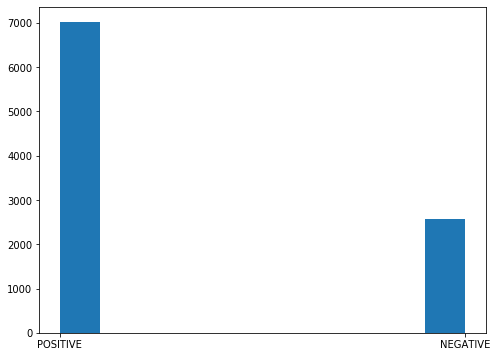

In [19]:
plt.figure (figsize = (8,6))
plt.hist (HongKong_pred_1d)
plt.show()